## Per-gridcell building damage analysis
#### This notebook shows the code to plot per-gridcell hail damages to buildings

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as PathEffects

from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim as sc

############################Definitions#######################################
event_def_version = 7
haz_var = 'MESHS' 
exposure = 'KGV' # Kantonale Gebäudeversicherungen (cantonal building insurances)


# set directories from CLIMADA config file
data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

# configuration_path
fig_path = '%s%s/v%d' %(exposure,haz_var, event_def_version)

Could not find bayes_opt. Module Calib_opt will not work.


In [2]:
# at centroids historgram
haz_var = 'MESHS'; min_count=10
values_at_centroid_all, values_at_centroid = sc.verification.get_at_centroids_data_from_csv(exposure,haz_var, event_def_version,min_count=min_count)
#Assert correctly fillen NaN values in cells with no exposure
values_at_centroid['PAA'] = values_at_centroid['n_dmgs']/values_at_centroid['n_exp']
values_at_centroid['MDR'] = values_at_centroid['dmg_val']/values_at_centroid['exp_val']

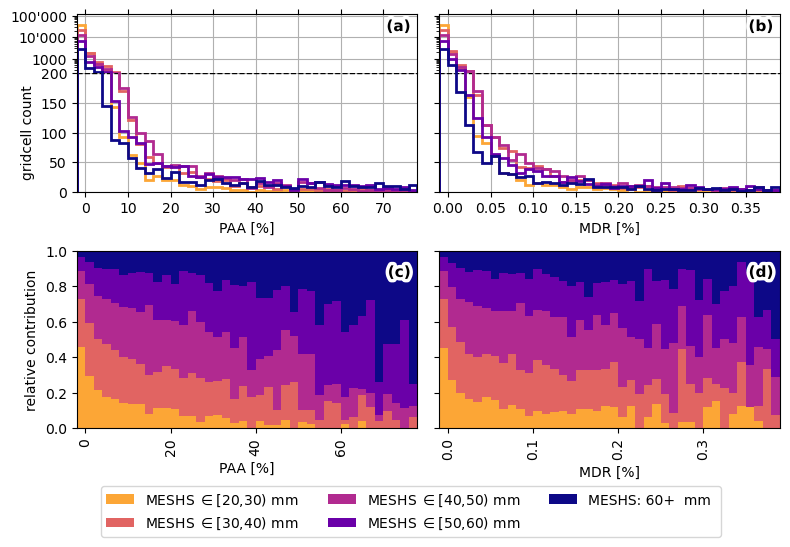

In [80]:
fig = plt.figure(layout="tight",figsize=(8,5))
gs = GridSpec(4, 2, figure=fig,height_ratios=[1,2,1,3],hspace=0)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[1,0])
ax10 = fig.add_subplot(gs[0, 1],sharey=ax00)
ax11 = fig.add_subplot(gs[1, 1],sharey=ax01)

ax02 = fig.add_subplot(gs[3,0])
ax12 = fig.add_subplot(gs[3,1],sharey=ax02)

_,(ax0a,ax0b) = sc.plot_funcs.set_up_broken_axis((0,200),ylim2=(200,1.2e5),hspace=0,height_ratio=(1,2),
                                                figsize=(6,4),figAxAx=(fig,ax00,ax01))
_,(ax1a,ax1b) = sc.plot_funcs.set_up_broken_axis((0,200),ylim2=(200,1.2e5),hspace=0,height_ratio=(1,2),
                                                figsize=(6,4),figAxAx=(fig,ax10,ax11))

#create list of colors from matplolib cmap
colors = plt.cm.get_cmap('plasma_r', 6)(np.linspace(0,1,6))
intervals = [(0,1),(20,30),(30,40),(40,50),(50,60),(60,np.inf)]

for imp_var, axes,x_lbl_type in zip(['PAA','MDR'],[[ax0a,ax0b,ax02],
                                    [ax1a,ax1b,ax12]],[int,float]):
    bin_size=2 if imp_var=='PAA' else 0.01
    bin_max = 80 if imp_var=='PAA' else 0.4
    bins=np.arange(-bin_size,bin_max,bin_size).astype(float)
    bins[bins==0]=1e-8#set 0 to small number to ensure 0 damages are counted in a separate bin

    #plot distribution
    for interval,col in zip(intervals[1:],colors[1:]):
        interval_str = f' $\in$[{interval[0]:.0f},{interval[1]:.0f})' if interval[1]<np.inf else f': {interval[0]:.0f}+  '
        values_at_centroid_sel = values_at_centroid.loc[(values_at_centroid[haz_var]>interval[0])&(values_at_centroid[haz_var]<interval[1]),:]
        for ax in axes[:2]:
            (values_at_centroid_sel[imp_var]*100).hist(bins=bins,label=f'{haz_var}{interval_str} {sc.constants.UNIT_DICT[haz_var]} ',ax=ax,
                                                histtype='step',lw=2,color=col)

    # axes[1].legend(loc='lower right',bbox_to_anchor=(1,0.85))
    axes[0].set(yscale='log',yticks=[1e3,1e4,1e5],yticklabels=["1000","10'000","100'000"],xlim=(bins[0],max(bins)))
    axes[1].set(xlabel=f'{imp_var} [%]',xlim=(bins[0],max(bins)),ylabel='gridcell count')


    #plot relative contribution
    include_lowest=False
    right=False

    vals_tot_all = values_at_centroid.groupby(pd.cut(values_at_centroid[imp_var],bins=bins/100,
        include_lowest=include_lowest,right=right)).centr_HL.count()
    vals_tot_nonzero = values_at_centroid.loc[values_at_centroid[haz_var]>0,:].groupby(pd.cut(values_at_centroid[imp_var],
        bins=bins/100,include_lowest=include_lowest,right=right)).centr_HL.count()

    for vals_tot,subsel in zip([vals_tot_all,vals_tot_nonzero],[np.arange(0,len(colors)),np.arange(1,len(colors))]):
        if subsel[0]==0:
            continue #skip the option without MESHS=0 for now
        ax = axes[2]
        
        bottom = np.zeros(len(vals_tot))
        for interval, color in zip(np.array(intervals)[subsel],np.array(colors)[subsel]):
            if interval[0]==0:
                interval_str = f': 0'
            elif interval[1]==np.inf:
                interval_str = f': {interval[0]:0n}+ '
            else:
                interval_str = f' $\in$[{interval[0]:0n},{interval[1]:0n})'

            values_at_centroid_sel = values_at_centroid.loc[(values_at_centroid[haz_var]>=interval[0])&
                                                            (values_at_centroid[haz_var]<interval[1]),:]

            vals_sel = values_at_centroid_sel.groupby(pd.cut(values_at_centroid_sel[imp_var],
                bins=bins/100,include_lowest=include_lowest,right=right)).centr_HL.count()
            vals_rel = vals_sel/vals_tot
            vals_rel.index = bins[1:] #only use right bin edge as label
            vals_rel.plot.bar(facecolor=color,edgecolor='none',bottom=bottom,
                label= f'{haz_var}{interval_str} {sc.constants.UNIT_DICT[haz_var]} ',
                width=1,ax=ax,align='edge')
            bottom += vals_rel

        xtick_pos = np.linspace(0,len(bins),int(len(bins)/10)+1).astype(int)[:-1] +1 #+1 to start at the 0 bin
        x_lbl = (np.round(bins[xtick_pos]/bin_size)*bin_size).astype(x_lbl_type)
        _=ax.set(xlabel=f'{imp_var} [%]',ylabel='relative contribution',xticks=xtick_pos,
                xticklabels=x_lbl,ylim=(0,1),xlim=(0,len(bins)-1))

for ax,label in zip([ax00,ax10,ax02,ax12],['(a)','(b)','(c)','(d)']):
    txt = ax.text(0.98,0.92,label,transform=ax.transAxes,fontsize=11,fontweight='bold',ha='right',va='top')
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    
h,l = ax.get_legend_handles_labels()    
fig.legend(h,l,loc='upper center',bbox_to_anchor=(0.52,0.03),ncol=3)
fig.savefig(f'{out_dir}/paper1/fig05.png', dpi=300, bbox_inches='tight')